# WeRateDogs清洗与分析数据

你在这个项目中的任务如下：

- 数据整理，其中包括：
    - 收集数据
    - 评估数据
    - 清洗数据
- 对清洗过的数据进行储存、分析和可视化
- 书面报告 1) 你的数据整理工作 和 2) 你的数据分析和可视化

## 收集

本项目需要从三种来源来收集三种不同格式的数据：
- WeRateDogs 的推特档案，直接通过read_csv读取；
- 推特图像的预测数据，通过Requests库从URL编程下载；
- 每条推特的额外附加数据，通过Tweepy库从推特API获取；

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.style.use('ggplot')

In [2]:
rate_df_origin = pd.read_csv('twitter-archive-enhanced.csv')

推特图像预测数据需要用Requests库从URL编程下载

In [3]:
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [4]:
image_df_origin = pd.read_csv('image-predictions.tsv', sep='\t')

每条推特的额外附加数据通过Tweepy库从推特API获取

In [5]:
# consumer_key = 'YOUR CONSUMER KEY'
# consumer_secret = 'YOUR CONSUMER SECRET'
# access_token = 'YOUR ACCESS TOKEN'
# access_secret = 'YOUR ACCESS SECRET'

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth)

**twitter API已经申请了很多天也没给回复，直接从tweet_json.txt中读取**

In [6]:
tweet_json = []
with open('tweet_json.txt', mode='r') as f:
    for line in f:
        tweet_json.append(json.loads(line))
        
tweet_df_origin = pd.DataFrame(tweet_json, columns = ['id', 'favorite_count', 'retweet_count'])
tweet_df_origin.rename(columns={'id': 'tweet_id'}, inplace=True)

在清理之前，保存原始数据的副本

In [7]:
rate_df = rate_df_origin.copy()
image_df = image_df_origin.copy()
tweet_df = tweet_df_origin.copy()

## 评估

### 可视化评估

首先对三个Dataframe进行可视化评估，以达到熟悉数据集，并粗略发现问题的目的。

In [8]:
rate_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


rate_df主要是狗狗的信息和评分，以及tweet的状态数据  
可视化可以得出：
- tweet_id设为索引
- rate_df中的source可以转化为类型特征
- doggo，floofer，pupper和puppo空值为'None'，应该改为NaN
- doggo，floofer，pupper和puppo这四个为狗狗的stage，可以合并成一个类型特征

In [9]:
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


image_df主要是用神经网络识别狗狗的品种  
可视化可以得出：
- tweet_id设为索引

In [10]:
tweet_df

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39492,8842
1,892177421306343426,33786,6480
2,891815181378084864,25445,4301
3,891689557279858688,42863,8925
4,891327558926688256,41016,9721
5,891087950875897856,20548,3240
6,890971913173991426,12053,2142
7,890729181411237888,66596,19548
8,890609185150312448,28187,4403
9,890240255349198849,32467,7684


tweet_df从API中主要提取了转发数（retweet_count）和喜欢数（favorite_count）  
可视化可以得出：
- tweet_id设为索引

### 编程评估

### 数据类型检查

In [11]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

数据类型转换：
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id转为int64
- timestamp, retweeted_status_timestamp转为Datetime
- source转为category

In [12]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
tweet_id          2352 non-null int64
favorite_count    2352 non-null int64
retweet_count     2352 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


可以看出rate_df有2356行，而image_df只有2075行，tweet_df只有2352行，存在行缺失

### 缺失值检查

In [14]:
rate_df['doggo'].unique()

array(['None', 'doggo'], dtype=object)

In [15]:
rate_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [16]:
rate_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
rate_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### 重复项检查

In [18]:
rate_df[rate_df.in_reply_to_status_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,None,None,None,None


In [19]:
image_df[image_df.duplicated()].any()

tweet_id    False
jpg_url     False
img_num     False
p1          False
p1_conf     False
p1_dog      False
p2          False
p2_conf     False
p2_dog      False
p3          False
p3_conf     False
p3_dog      False
dtype: bool

In [20]:
tweet_df[tweet_df.duplicated()].any()

tweet_id          False
favorite_count    False
retweet_count     False
dtype: bool

缺失值

duplicated

### 特定特征值观察

In [21]:
rate_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

观察可以看出，首字母小写的大部分是不正确的

In [22]:
rate_df[(rate_df.name.str[0] >= 'a') & (rate_df.name.str[0] <= 'z')]['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

rate_df中name字段存在不正确的名字，如'None'，'a', 'one'，'this', 'not'等等

In [23]:
rate_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

rating_numerator有1776非常大的评分

In [24]:
rate_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

rating_denominator分母有为0的评分

In [25]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

rate_df中的特征retweeted_status_id，retweeted_status_user_id，retweeted_status_timestamp不为null则说明是twitter转发，应过滤掉

- 质量：内容问题。低质量数据也称为脏数据。
- 整洁度：使分析难易进行的问题。不整洁数据也称为杂乱数据。条理数据的要求包括：
    - 每个变量成一列。
    - 每个观察结果成一行。
    - 每种观察单位构成一个表格。

数据质量维度：
- 完整性：我们是否记录了所有内容？是否缺少记录？是否丢失某个行、列或单元格？
- 有效性：我们已经做了记录，但却无效，即它们不符合定义的模式。模式是一组定义的数据规则。这些规则可以是真实世界约定成俗的事实（例如身高不可能是负数）和表格约定成俗的属性（例如表中的唯一键）。
- 准确性：不准确的数据是有效的，但仍然是错误的。这些数据符合定义的模式，但仍然不正确。例如：每个患者体重被多记录了5磅。虽然有失偏颇，这些数据仍然是有效的，但并不理想。
- 一致性：不一致的数据是有效和准确的，但是指代同一件事情的正确方式有多个。最好确保表和/或表内表示相同数据的列中的数据具有一致性，即采用标准格式。

In [26]:
rate_df.timestamp.max()

'2017-08-01 16:23:56 +0000'

目测评估与编程评估，列出至少 8 个质量问题 和 2 个清洁度问题。要符合项目规范，必须对项目动机中的要求进行评估

### 评估总结

质量问题：
- tweet_id设为索引
- rate_df中的source可以转化为类型特征
- doggo，floofer，pupper和puppo空值为'None'，应该改为NaN
- 数据类型转换：in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id转为int64
- 数据类型转换：timestamp, retweeted_status_timestamp转为Datetime
- 可以看出rate_df有2356行，而image_df只有2075行，tweet_df只有2352行，存在行缺失
- rate_df中name字段存在不正确的名字，如'None'，'a', 'one'，'this', 'not'等等
- rating_numerator和rating_denominator有不正确的评分
- rate_df中的特征retweeted_status_id，retweeted_status_user_id，retweeted_status_timestamp不为null则说明是twitter转发，应过滤掉

清洁度问题：
- doggo，floofer，pupper和puppo这四个为狗狗的stage，可以合并成一个类型特征
- 三个表为同一个观察单位，应合并成一个表格

## 清洗

清洗数据的要点：
- 只需原始评级，过滤掉转发
- 要求只是评估和清理此数据集中的至少 8 个质量问题和至少 2 个整洁度问题
- tidy data 本项目的数据清理应该包括将三个数据片段进行合并
- 分子评级超过分母评级，不需要进行清洗
- 不必收集 2017 年 8 月 1 日之后的数据

### tweet_id设为索引，再作三表合并，并清除掉image_df和tweet_df中的缺失行

#### 定义

将tweet_id设为索引，并join，清除掉image_df和tweet_df中特征缺失的行

#### 代码

In [27]:
rate_df.set_index('tweet_id', inplace=True)
image_df.set_index('tweet_id', inplace=True)
tweet_df.set_index('tweet_id', inplace=True)

rate_df = rate_df.join(image_df)
rate_df = rate_df.join(tweet_df)

rate_df = rate_df[~rate_df.jpg_url.isnull()]
rate_df = rate_df[~rate_df.favorite_count.isnull()]

#### 测试

In [28]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 892420643555336193 to 666020888022790149
Data columns (total 29 columns):
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
jpg_url                       2073 non-null object
img

### 只需原始评级，过滤掉转发

#### 定义
只保留retweeted_status_id为null的数据，并移除相关特征retweeted_status_id，retweeted_status_user_id，retweeted_status_timestamp，回复暂时未过滤

#### 代码

In [29]:
rate_df = rate_df[rate_df.retweeted_status_id.isnull()]

rate_df.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True, axis=1)

#### 测试

In [30]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 892420643555336193 to 666020888022790149
Data columns (total 26 columns):
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-nu

### 数据类型转换

#### 定义
- source裁剪多余的字符，并转为类型特征
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id转为int64
- timestamp转为Datetime
- join之后img_num，favorite_count，retweet_count变为float64，也需要转回为int64

#### 代码

In [31]:
rate_df.source = rate_df.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])
rate_df.source = rate_df.source.astype('category')

rate_df.fillna({'in_reply_to_status_id':0, 'in_reply_to_user_id':0}, inplace=True)
rate_df.in_reply_to_status_id = rate_df.in_reply_to_status_id.astype('int64')
rate_df.in_reply_to_user_id = rate_df.in_reply_to_user_id.astype('int64')

rate_df.timestamp = pd.to_datetime(rate_df.timestamp)

rate_df.img_num = rate_df.img_num.astype('int64')
rate_df.favorite_count = rate_df.favorite_count.astype('int64')
rate_df.retweet_count = rate_df.retweet_count.astype('int64')

#### 测试

In [32]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 892420643555336193 to 666020888022790149
Data columns (total 26 columns):
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null category
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       199

In [33]:
rate_df.source.unique()

[Twitter for iPhone, Twitter Web Client, TweetDeck]
Categories (3, object): [Twitter for iPhone, Twitter Web Client, TweetDeck]

### doggo，floofer，pupper和puppo空值为'None'，应该改为NaN，并合并为stage类型特征

#### 定义
对doggo，floofer，pupper和puppo使用melt，并去重，这里如果属于多个种类，只保留一个

#### 代码

In [34]:
rate_df.reset_index(inplace=True)

columns_to_melt = set(['doggo', 'floofer', 'pupper', 'puppo'])
columns_to_stay = set(rate_df.columns) - columns_to_melt


rate_df = rate_df.melt(id_vars = columns_to_stay, value_vars = columns_to_melt, var_name='dog_stages', value_name='stage')

In [35]:
rate_df = rate_df.sort_values('stage').drop_duplicates('tweet_id', keep = 'last')

rate_df.drop('dog_stages', axis=1, inplace=True)

rate_df.sort_values('tweet_id', inplace=True)

# rate_df.reset_index(drop=True, inplace=True)

rate_df.set_index('tweet_id', inplace=True)

rate_df.loc[rate_df.stage == 'None', 'stage'] = np.nan

#### 测试

In [36]:
rate_df.head()

,rating_numerator,rating_denominator,text,retweet_count,jpg_url,name,img_num,in_reply_to_user_id,in_reply_to_status_id,p2_dog,...,p3_dog,expanded_urls,favorite_count,p2,source,p3,p2_conf,p1,timestamp,stage
tweet_id,,,,,,,,,,,,,,,,,,,,,
666020888022790149,8,10,Here we have a Japanese Irish Setter. Lost eye...,530,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,None,1,0,0,True,...,True,https://twitter.com/dog_rates/status/666020888...,2528,collie,Twitter for iPhone,Shetland_sheepdog,0.156665,Welsh_springer_spaniel,2015-11-15 22:32:08,NaN
666029285002620928,7,10,This is a western brown Mitsubishi terrier. Up...,48,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,a,1,0,0,True,...,True,https://twitter.com/dog_rates/status/666029285...,132,miniature_pinscher,Twitter for iPhone,Rhodesian_ridgeback,0.074192,redbone,2015-11-15 23:05:30,NaN
666033412701032449,9,10,Here is a very happy pup. Big fan of well-main...,47,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,a,1,0,0,True,...,True,https://twitter.com/dog_rates/status/666033412...,128,malinois,Twitter for iPhone,bloodhound,0.138584,German_shepherd,2015-11-15 23:21:54,NaN
666044226329800704,6,10,This is a purebred Piers Morgan. Loves to Netf...,147,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,a,1,0,0,True,...,True,https://twitter.com/dog_rates/status/666044226...,309,redbone,Twitter for iPhone,miniature_pinscher,0.360687,Rhodesian_ridgeback,2015-11-16 00:04:52,NaN
666049248165822465,5,10,Here we have a 1949 1st generation vulpix. Enj...,41,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,None,1,0,0,True,...,True,https://twitter.com/dog_rates/status/666049248...,111,Rottweiler,Twitter for iPhone,Doberman,0.243682,miniature_pinscher,2015-11-16 00:24:50,NaN


In [37]:
rate_df.stage.value_counts()

pupper     212
doggo       63
puppo       23
floofer      8
Name: stage, dtype: int64

### name移除错误的名字

#### 定义
rate_df中name字段存在不正确的名字，如'a', 'one'，'this', 'not'等等，可以看出，名字是从text中提取的，这些错误的名字是由于错误提取导致的，这里简单的处理方式是把小写开头的都当作是错误名字，改为'None'，然后把所有的'None'设为NaN

#### 代码

In [38]:
rate_df.loc[(rate_df.name.str[0] >= 'a') & (rate_df.name.str[0] <= 'z'), 'name'] = 'None'

In [39]:
rate_df.loc[rate_df.name=='None', 'name'] = np.nan

#### 测试

In [40]:
rate_df.name.value_counts()

Charlie     11
Cooper      10
Oliver      10
Lucy        10
Penny        9
Tucker       9
Sadie        8
Winston      8
Toby         7
Daisy        7
Lola         7
Koda         6
Jax          6
Bo           6
Stanley      6
Bella        6
Scout        5
Louis        5
Rusty        5
Chester      5
Dave         5
Buddy        5
Bailey       5
Leo          5
Oscar        5
Milo         5
Gary         4
Alfie        4
Duke         4
Jerry        4
            ..
Dewey        1
Levi         1
Banjo        1
Shaggy       1
Mutt         1
Ralphie      1
Murphy       1
Mabel        1
Cermet       1
Boston       1
Nimbus       1
Freddery     1
Cheryl       1
Rhino        1
Bobbay       1
Mairi        1
Fido         1
Birf         1
Ralphson     1
Herb         1
Leonidas     1
Yoda         1
Emmie        1
Comet        1
Newt         1
Jessifer     1
Diogi        1
Edmund       1
Blue         1
Brudge       1
Name: name, Length: 913, dtype: int64

In [41]:
rate_df[rate_df.name.isnull()]['text']

tweet_id
666020888022790149    Here we have a Japanese Irish Setter. Lost eye...
666029285002620928    This is a western brown Mitsubishi terrier. Up...
666033412701032449    Here is a very happy pup. Big fan of well-main...
666044226329800704    This is a purebred Piers Morgan. Loves to Netf...
666049248165822465    Here we have a 1949 1st generation vulpix. Enj...
666050758794694657    This is a truly beautiful English Wilson Staff...
666051853826850816    This is an odd dog. Hard on the outside but lo...
666055525042405380    Here is a Siberian heavily armored polar bear ...
666057090499244032    My oh my. This is a rare blond Canadian terrie...
666058600524156928    Here is the Rand Paul of retrievers folks! He'...
666063827256086533    This is the happiest dog you will ever see. Ve...
666071193221509120    Here we have a northern speckled Rhododendron....
666073100786774016    Let's hope this flight isn't Malaysian (lol). ...
666082916733198337    Here we have a well-established s

### 评分不正确

#### 定义
这里选择移除掉某些评分明显不正确的数据

#### 代码

In [42]:
rate_df.drop(index=rate_df[rate_df.rating_numerator == 1776].index, inplace=True)
rate_df.drop(index=rate_df[rate_df.rating_numerator == 420].index, inplace=True)

#### 测试

In [43]:
rate_df.rating_numerator.value_counts()

12     450
10     419
11     396
13     261
9      151
8       95
7       52
14      35
5       33
6       32
3       19
4       16
2        9
1        5
0        2
165      1
204      1
26       1
27       1
44       1
45       1
50       1
60       1
75       1
80       1
84       1
88       1
99       1
121      1
143      1
144      1
24       1
Name: rating_numerator, dtype: int64

In [44]:
rate_df.rating_denominator.value_counts()

10     1974
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

## 存储、分析和可视化

命名为 twitter_archive_master.csv。如果有其他观察对象的数据集存在，需要多个表格，那么要给这些文件合理命名。

必须生成至少 3 个见解和 1 个可视化。

添加评分特征

In [45]:
rate_df['rating'] = rate_df.rating_numerator / rate_df.rating_denominator

### 存储

In [46]:
rate_df.to_csv('twitter_archive_master.csv', encoding='utf-8')

### 特征相关性分析

Text(0.5,1,'Features Correlation')

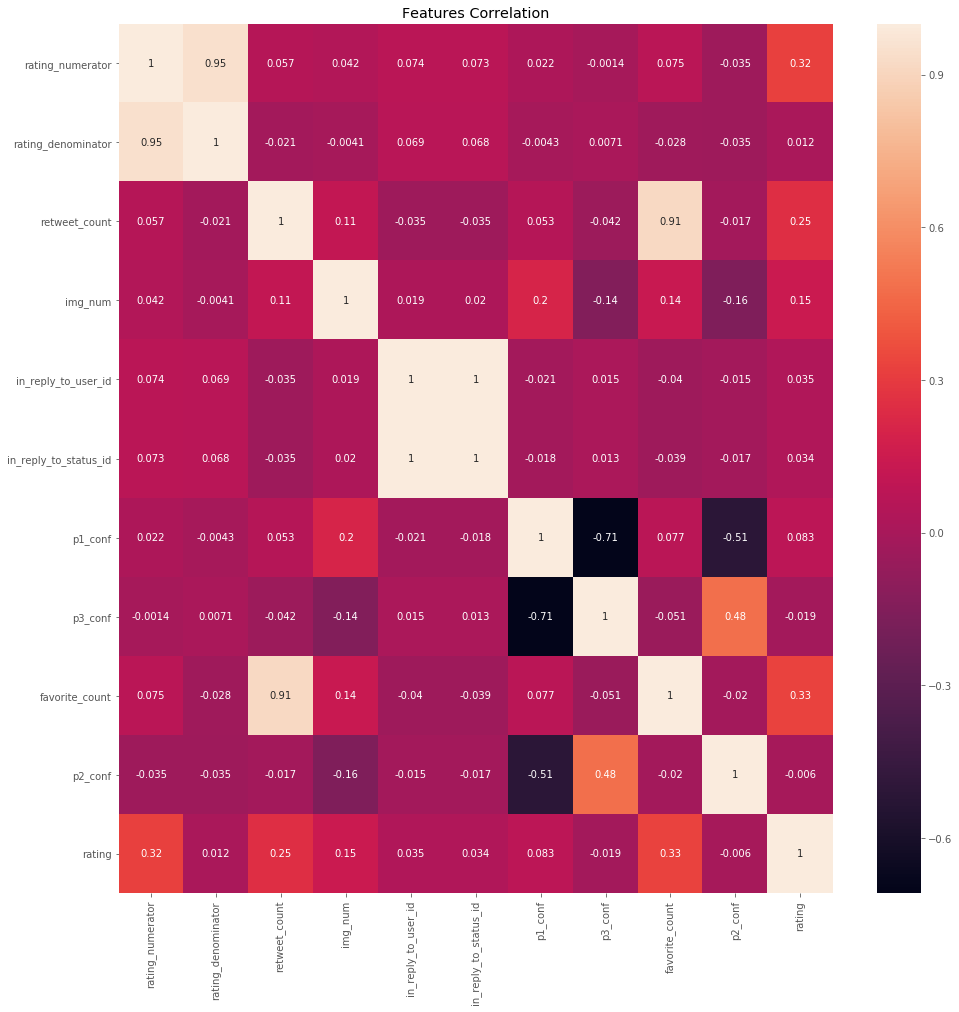

In [47]:
corr = rate_df.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, annot=True)
plt.title('Features Correlation')

相关性分析可以看出：
- 相关性最强的是rating_numerator，评分分子越高，评分也越高这是很显然的。
- 评分跟favorite_count，retweet_count相关性很高，说明越受欢迎大众欢迎，评分越高，评分是参考了大众趋势的。
- img_num图片数量比较多时,评分也较高，资料更多也说明了重视程度更高。

### 推特附加数据分析

Text(0.5,1,'Favorite and Retweet Scatter Plot')

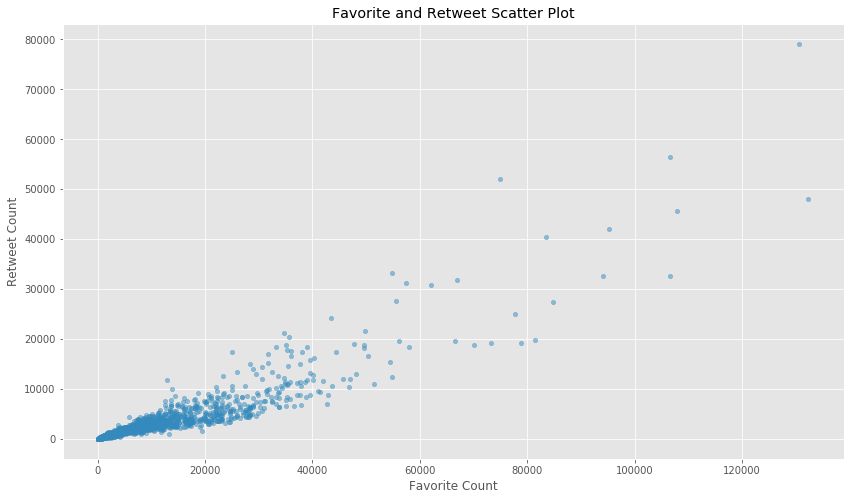

In [48]:
rate_df.plot(kind='scatter', x='favorite_count', y='retweet_count', alpha=0.5, figsize=(14, 8))
plt.xlabel('Favorite Count')
plt.ylabel('Retweet Count')
plt.title('Favorite and Retweet Scatter Plot')

从散点图可以看出，这favorite_count和retweet_count具有很强的正相关性，点赞次数越多，则转发次数越多

### 评分的时间序列分析

Text(0,0.5,'Rating')

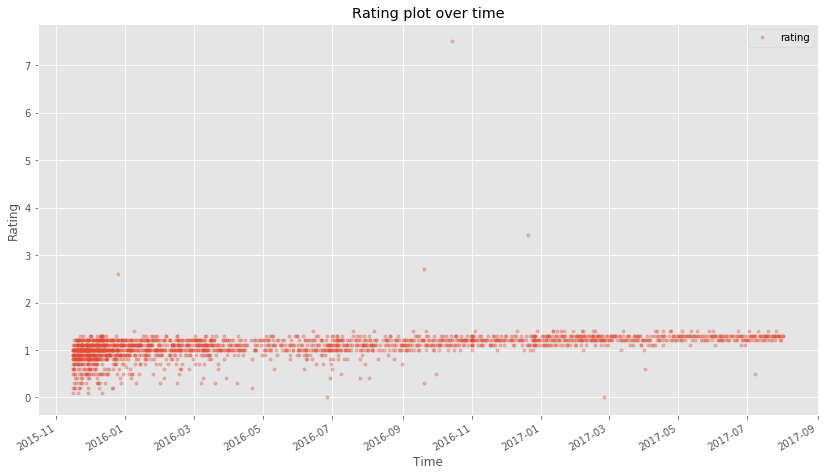

In [49]:
rate_df.plot(x='timestamp', y='rating', style='.', alpha=0.3, figsize=(14, 8))
plt.title('Rating plot over time')
plt.xlabel('Time')
plt.ylabel('Rating')

In [50]:
rate_df.rating.describe()

count    1992.000000
mean        1.060182
std         0.272356
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         7.500000
Name: rating, dtype: float64

从时间序列分析可以看出：
- 可以看出大部分的评分在1.1左右，通常rating_numerator比rating_denominator高
- 作者的整体评分有上升趋势，尤其是低评分段，在2016年初还有很多低评分存在，从2016年下半年开始逐渐消失，推测有两种原因，一是可能twitter主更多关注热度更高的狗狗，也有可能是评分方面更加宽容。

### stage比例分布

In [51]:
stage_vc = rate_df[rate_df.stage.notna()].stage.value_counts()

In [52]:
labels = stage_vc.index.tolist()
sizes = stage_vc.tolist()

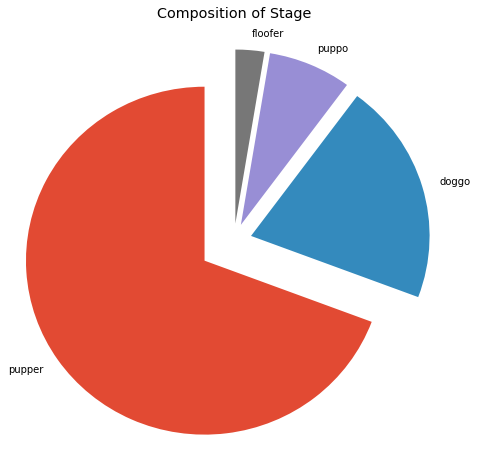

In [53]:
plt.figure(figsize=(8, 8))
explode = (0.2, 0.1, 0.1, 0.1) 
plt.pie(sizes, labels=labels, explode=explode, startangle=90)
plt.title('Composition of Stage');

从饼图可以看出，pupper的比例最高，占了三分之二，doggo次之，floofer最少。

### source比例分布

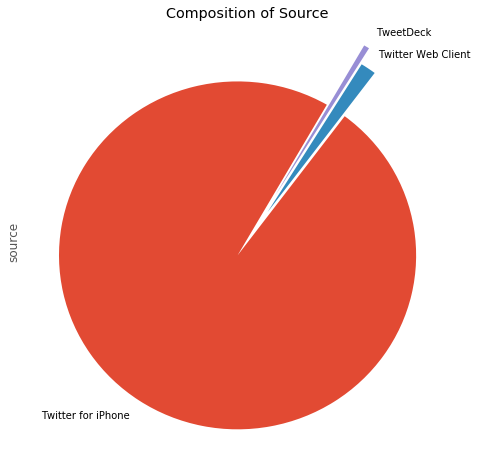

In [54]:
plt.figure(figsize=(8, 8))
explode = (0.1, 0.2, 0.3)
rate_df.source.value_counts().plot(x='stage', kind='pie',explode=explode, startangle=60)
plt.title('Composition of Source');

从饼图可以看出，绝大多数twitter是通过手机端发布的

### 流行的狗狗名字

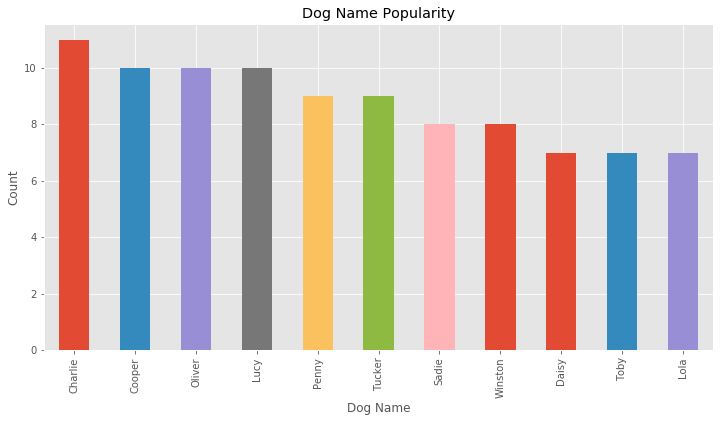

In [55]:
plt.figure(figsize=(12, 6))
rate_df.name.value_counts()[:11].plot(x='name', kind='bar')
plt.xlabel('Dog Name')
plt.ylabel('Count')
plt.title('Dog Name Popularity');

在WeRateDogs的twitter中，最流行的狗狗名依次是：Charlie, Cooper, Oliver, Lucy, Tucker, Penny, Winston, Sadie, Lola, Daisy, Toby

### stage评分箱线图

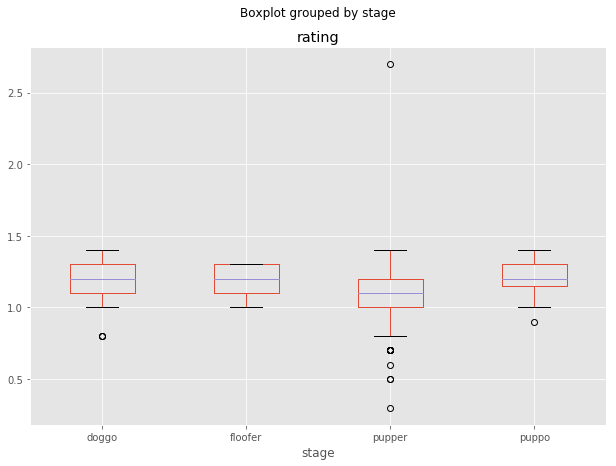

In [56]:
rate_df[rate_df['stage'].notna()].boxplot(column='rating', by='stage', figsize=(10, 7));

从箱线图可以得出，四种stage中，pupper得分相对最低，而且outlier最多，大部分也是偏低的，其他三类的分布是差不多的，puppo的下四分位数更高。

### 预测成功率最高的品种

In [57]:
dogs = rate_df[rate_df.p1_dog].sort_values('p1_conf', ascending=False)[:50][['p1', 'p1_conf']]
dogs

,p1,p1_conf
tweet_id,,
668636665813057536,komondor,0.999956
762464539388485633,chow,0.999953
697463031882764288,Labrador_retriever,0.999885
675149409102012420,chow,0.999876
709566166965075968,chow,0.999837
814986499976527872,dalmatian,0.999828
777621514455814149,chow,0.999823
831322785565769729,Old_English_sheepdog,0.999715
680115823365742593,pug,0.999365


In [58]:
dogs.p1.value_counts()

pug                     8
Pomeranian              5
French_bulldog          4
chow                    4
Samoyed                 3
Labrador_retriever      3
basset                  2
golden_retriever        2
Pembroke                2
Saint_Bernard           2
keeshond                2
collie                  1
Old_English_sheepdog    1
Great_Pyrenees          1
beagle                  1
German_shepherd         1
dalmatian               1
komondor                1
Great_Dane              1
Chihuahua               1
Bernese_mountain_dog    1
Blenheim_spaniel        1
Rottweiler              1
schipperke              1
Name: p1, dtype: int64

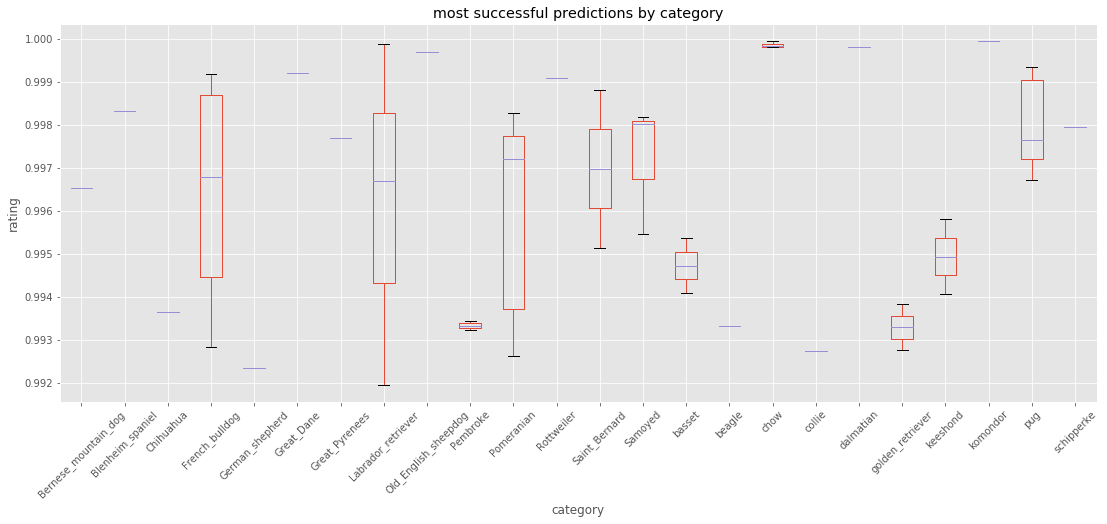

In [59]:
dogs.boxplot(column='p1_conf', by='p1', figsize=(18, 7))
plt.xlabel('category')
plt.ylabel('rating')
plt.xticks(rotation=45)
plt.title('most successful predictions by category')
plt.suptitle('');

In [60]:
pd.DataFrame(rate_df[rate_df.p1_dog].groupby('p1')['p1_conf'].median().nlargest(10)).reset_index().rename(columns={'p1':'category', 'p1_conf':'prediction'})

,category,prediction
0,komondor,0.974781
1,clumber,0.946718
2,keeshond,0.936476
3,Samoyed,0.923149
4,Brittany_spaniel,0.922876
5,Blenheim_spaniel,0.915452
6,pug,0.867334
7,French_bulldog,0.865162
8,German_short-haired_pointer,0.835491
9,Pomeranian,0.833249


从预测前50名的分布情况可以看出：
- komondor, chow, dalmatian, Old_English_sheepdog整体预测率最高
- 在高预测率的品种中，pug数量最多，占到8个，Pomeranian5个，chow和French_bulldog为四个  


整体groupby之后的结果，预测品种排名前5分别为：komondor, clumber, keeshond, Samoyed, Brittany_spaniel